# Distributed CBO -- Benchmark and Comparison

In [1]:
%load_ext autoreload
%autoreload 2

from dataclasses import dataclass
import math
import time
from typing import List

import matplotlib.pyplot as plt
import numpy as np

from cbx.dynamics import CBO, DistributedCBO
from cbx.objectives import Rastrigin, Ackley, Michalewicz
import cbx.utils.termination as term

# CBO Configuration

In [2]:
conf = {
    'alpha': 40.0,
    'dt': 0.1,
    'sigma': 1.,
    'lamda': 1.0,
    'term_criteria': [term.max_it_term(100)],
    'track_args': {'names': ['update_norm', 'energy', 'x', 'consensus', 'drift']},

    'noise': 'anisotropic',
    'f_dim': '3D'
}

# Define Benchmarking Functions

In [3]:
def benchmark_distributed_cbo_splitting_factor(
    f: callable,
    num_runs: int,
    max_splitting_factor: int,
    max_particles: int,
    synchronization_interval: int,
    synchronization_method: str,
    num_steps: int,
    use_async_communication: bool = False,
    axs=None,
    fmin=0
):  
    energy_means = []
    execution_times = []
    function_evaluations = []
    quantile_10 = []
    quantile_90 = []
    success_rates = {splitting_factor: 0 for splitting_factor in range(1, max_splitting_factor + 1)}
    for splitting_factor in range(1, max_splitting_factor + 1):
        num_particles = math.ceil(max_particles / splitting_factor)
        current_energies = []
        for _ in range(num_runs):
            dyn = DistributedCBO(
                f=f,
                num_agent_batches=splitting_factor,
                synchronization_interval=synchronization_interval,
                synchronization_method=synchronization_method,
                use_async_communication=use_async_communication,
                N=num_particles,
                verbose=False,
                max_it=10000,
                **conf
            )

            # Run optimization and measure time
            tick = time.time()
            current_energies.append(
                f(dyn.optimize(num_steps=num_steps, sched='default'))
            )
            tock = time.time()
            execution_times.append(tock - tick)

            # Check if we found true minimum
            if abs(current_energies[-1] - fmin) < 1e-3:
                success_rates[splitting_factor] += 1

            function_evaluations.append(dyn.num_f_eval())

        average_energy = np.median(current_energies)
        average_function_evaluations = np.mean(function_evaluations)
        print(f"Splitting factor: {splitting_factor}, average energy: {average_energy}, success_rate: {success_rates[splitting_factor] / num_runs}, function evaluations: {average_function_evaluations}, execution time: {np.mean(execution_times)}")
        energy_means.append(average_energy)

        quantile_10.append(np.percentile(current_energies, 5))
        quantile_90.append(np.percentile(current_energies, 95))

    if axs is not None:
        async_label = 'Async' if use_async_communication else 'Sync'
        axs.plot(list(range(1, max_splitting_factor + 1)), energy_means, label=f'Distributed CBO {async_label}')
        # Plot shaded confidence interval for energy from 10th to 90th percentile
        axs.fill_between(list(range(1, max_splitting_factor + 1)), quantile_10, quantile_90, alpha=0.3, label='90% CI')

    return np.argmin(energy_means) + 1


In [4]:
def benchmark_distributed_cbo_synchronization_interval(
    f: callable,
    num_runs: int,
    synchronization_intervals: List[int],
    max_particles: int,
    splitting_factor: int,
    synchronization_method: str,
    num_steps: int,
    use_async_communication: bool = False,
    axs=None,
    fmin=0
):  
    energy_means = []
    execution_times = []
    function_evaluations = []
    quantile_10 = []
    quantile_90 = []
    success_rates = {synchronization_interval: 0 for synchronization_interval in synchronization_intervals}
    for synchronization_interval in synchronization_intervals:
        num_particles = math.ceil(max_particles / splitting_factor)
        current_energies = []
        for _ in range(num_runs):
            dyn = DistributedCBO(
                f=f,
                num_agent_batches=splitting_factor,
                synchronization_interval=synchronization_interval,
                synchronization_method=synchronization_method,
                use_async_communication=use_async_communication,
                N=num_particles,
                verbose=False,
                max_it=10000,
                **conf
            )

            # Run optimization and measure time
            tick = time.time()
            current_energies.append(
                f(dyn.optimize(num_steps=num_steps, sched='default'))
            )
            tock = time.time()
            execution_times.append(tock - tick)

            # Check if we found true minimum
            if abs(current_energies[-1] - fmin) < 1e-3:
                success_rates[synchronization_interval] += 1

            function_evaluations.append(dyn.num_f_eval())

        average_energy = np.median(current_energies)
        average_function_evaluations = np.mean(function_evaluations)
        print(f"Synchronization interval: {synchronization_interval}, average energy: {average_energy}, success_rate: {success_rates[synchronization_interval] / num_runs}, function evaluations: {average_function_evaluations}, execution time: {np.mean(execution_times)}")
        energy_means.append(average_energy)

        quantile_10.append(np.percentile(current_energies, 5))
        quantile_90.append(np.percentile(current_energies, 95))

    if axs is not None:
        async_label = 'Async' if use_async_communication else 'Sync'
        axs.plot(synchronization_intervals, energy_means, label=f'Distributed CBO {async_label}')
        axs.set_xticks(synchronization_intervals)
        # Plot shaded confidence interval for energy from 10th to 90th percentile
        # axs.fill_between(synchronization_intervals, quantile_10, quantile_90, alpha=0.3, label='90% CI')


In [5]:
def benchmark_standard_cbo(
    f: callable,
    num_runs: int,
    num_particles: int,
    axs=None,
    fmin=0
):
    energies = []
    execution_times = []
    function_evaluations = []
    quantile_10 = []
    quantile_90 = []
    success_rate = 0
    for _ in range(num_runs):
        dyn = CBO(
            f,
            N=num_particles,
            verbosity=0,
            max_it=10000,
            batch_args=None,
            M=1,
            **conf
        )

        # Run optimization and measure time
        tick = time.time()
        energies.append(
            f(dyn.optimize())
        )
        tock = time.time()
        execution_times.append(tock - tick)

        if abs(energies[-1] - fmin) < 1e-3:
            success_rate += 1

        function_evaluations.append(dyn.num_f_eval)

    average_energy = np.median(energies)
    average_function_evaluations = np.mean(function_evaluations)
    print(f"Average energy: {average_energy}, success_rate: {success_rate / num_runs}, function evaluations: {average_function_evaluations}, execution time: {np.mean(execution_times)}")
    quantile_10.append(np.percentile(energies, 5))
    quantile_90.append(np.percentile(energies, 95))

    # Plot mean of undistributed energies as a horizontal line
    if axs is not None:
        axs.axhline(y=average_energy, color='r', linestyle='--', label='Standard CBO')
        # Plot shaded confidence interval for energy from 10th to 90th percentile
        # axs.fill_between([0, 1], quantile_10, quantile_90, alpha=0.3, label='90% CI')


# Benchmark

In [6]:
# Benchmarking params
NUM_RUNS = 100
MAX_SPLITTING_FACTOR = 10
MAX_PARTICLES = 100
SYNCHRONIZATION_INTERVAL = 10
SYNCHRONIZATION_METHOD = 'weighted_mean'

In [7]:
def run_experiment(
    f: callable,
    d: int,
    n: int,
):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    conf['d'] = d
    # Baseline (standard CBO)
    print("Standard CBO:")
    print("=============")
    benchmark_standard_cbo(
        f=f,
        num_runs=NUM_RUNS,
        num_particles=n,
        axs=axs[0]
    )
    print()

    # Synchronous
    print("Distributed CBO (synchronous communication):")
    print("=============================================")
    best_splitting_factor_sync = benchmark_distributed_cbo_splitting_factor(
        f=f,
        use_async_communication=False,
        num_runs=NUM_RUNS,
        max_splitting_factor=MAX_SPLITTING_FACTOR,
        max_particles=n,
        synchronization_interval=SYNCHRONIZATION_INTERVAL,
        synchronization_method=SYNCHRONIZATION_METHOD,
        num_steps=100,
        axs=axs[0]
    )
    print()

    # Asynchronous
    print("Distributed CBO (asynchronous communication):")
    print("==============================================")
    best_splitting_factor_async = benchmark_distributed_cbo_splitting_factor(
        f=f,
        use_async_communication=True,
        num_runs=NUM_RUNS,
        max_splitting_factor=MAX_SPLITTING_FACTOR,
        max_particles=n,
        synchronization_interval=SYNCHRONIZATION_INTERVAL,
        synchronization_method=SYNCHRONIZATION_METHOD,
        num_steps=100,
        axs=axs[0]
    )
    print()

    function_label = f.__class__.__name__ + f" dim={d}"
    axs[0].set_xlabel(f"Splitting factor")
    axs[0].set_ylabel(f"Mean energy")
    axs[0].set_title(f"{function_label}\nsync interval: {SYNCHRONIZATION_INTERVAL}, sync method: {SYNCHRONIZATION_METHOD}, particles: {n}")
    axs[0].legend()

    ############################################################################

    # Baseline (standard CBO)
    print("Standard CBO:")
    print("=============")
    benchmark_standard_cbo(
        f=f,
        num_runs=NUM_RUNS,
        num_particles=n,
        axs=axs[1]
    )
    print()

    # Synchronous
    print("Distributed CBO (synchronous communication):")
    print("=============================================")
    """
    f: callable,
    num_runs: int,
    synchronization_intervals: List[int],
    max_particles: int,
    splitting_factor: int,
    synchronization_method: str,
    num_steps: int,
    use_async_communication: bool = False,
    axs=None,
    fmin=0
    """
    benchmark_distributed_cbo_synchronization_interval(
        f=f,
        use_async_communication=False,
        num_runs=NUM_RUNS,
        splitting_factor=best_splitting_factor_sync,
        max_particles=n,
        synchronization_intervals=[10, 20, 30, 40, 50, 200],
        synchronization_method=SYNCHRONIZATION_METHOD,
        num_steps=100,
        axs=axs[1]
    )
    print()

    # Asynchronous
    print("Distributed CBO (asynchronous communication):")
    print("==============================================")
    benchmark_distributed_cbo_synchronization_interval(
        f=f,
        use_async_communication=True,
        num_runs=NUM_RUNS,
        splitting_factor=best_splitting_factor_async,
        max_particles=n,
        synchronization_intervals=[10, 20, 30, 40, 50, 200],
        synchronization_method=SYNCHRONIZATION_METHOD,
        num_steps=100,
        axs=axs[1]
    )
    print()

    function_label = f.__class__.__name__ + f" dim={d}"
    axs[1].set_xlabel(f"Synchronization interval")
    axs[1].set_ylabel(f"Mean energy")
    axs[1].set_title(f"{function_label}\nsplitting factor (sync, async): {best_splitting_factor_sync, best_splitting_factor_async}, sync method: {SYNCHRONIZATION_METHOD}, particles: {n}")
    axs[1].legend()
    
    fig.show()

## Ackley (d = 5, 10, 20; N = 50, 100, 200, 1000)

Standard CBO:
Average energy: 0.021816073530138258, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.00775113582611084

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.018356407771188632, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.015979835987091063
Splitting factor: 2, average energy: 0.016066193152840302, success_rate: 0.01, function evaluations: 5050.0, execution time: 0.01786117076873779
Splitting factor: 3, average energy: 0.020098720884093257, success_rate: 0.01, function evaluations: 5083.666666666667, execution time: 0.021180405616760253
Splitting factor: 4, average energy: 0.025501278448948117, success_rate: 0.01, function evaluations: 5125.75, execution time: 0.025344459414482115
Splitting factor: 5, average energy: 0.03897274745630819, success_rate: 0.0, function evaluations: 5110.6, execution time: 0.02946826696395874
Splitting factor: 6, average energy: 0.031187672740261352, success_rate: 0.0, fu

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_45722/1317182838.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


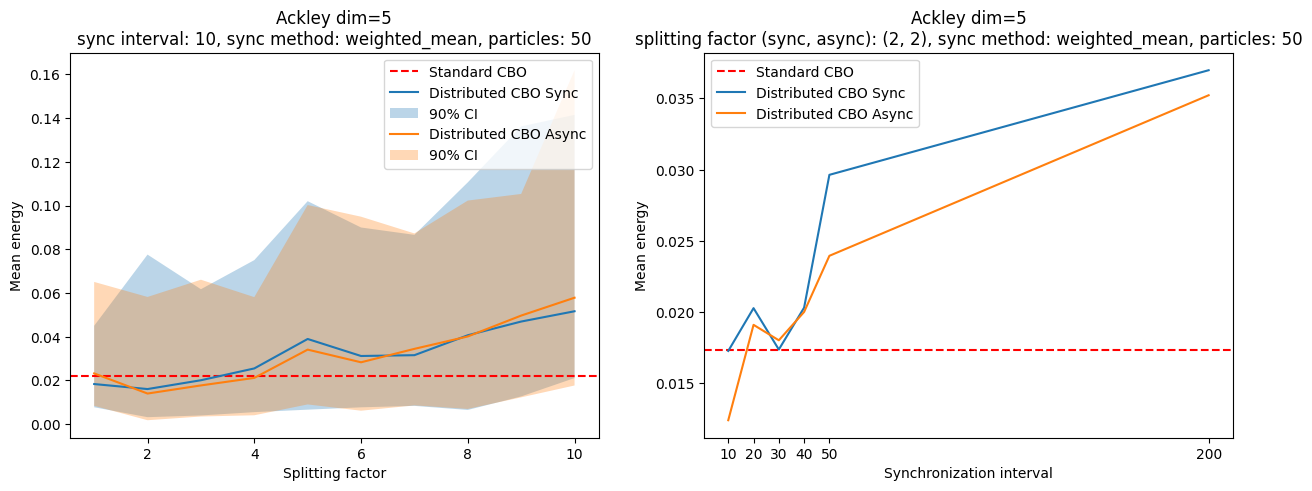

In [8]:
run_experiment(Ackley(), d=5, n=50)

Standard CBO:
Average energy: 0.12889459327106012, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.008360986709594726

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.12704714524644745, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.016435251235961915
Splitting factor: 2, average energy: 0.1300261376037004, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.018220332860946657
Splitting factor: 3, average energy: 0.12350239553503828, success_rate: 0.0, function evaluations: 5083.666666666667, execution time: 0.022022411028544107
Splitting factor: 4, average energy: 0.1423006807542273, success_rate: 0.0, function evaluations: 5125.75, execution time: 0.026326674818992615
Splitting factor: 5, average energy: 0.15901312993853844, success_rate: 0.0, function evaluations: 5110.6, execution time: 0.03082735252380371
Splitting factor: 6, average energy: 0.15956164153476182, success_rate: 0.0, function ev

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_45722/1317182838.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


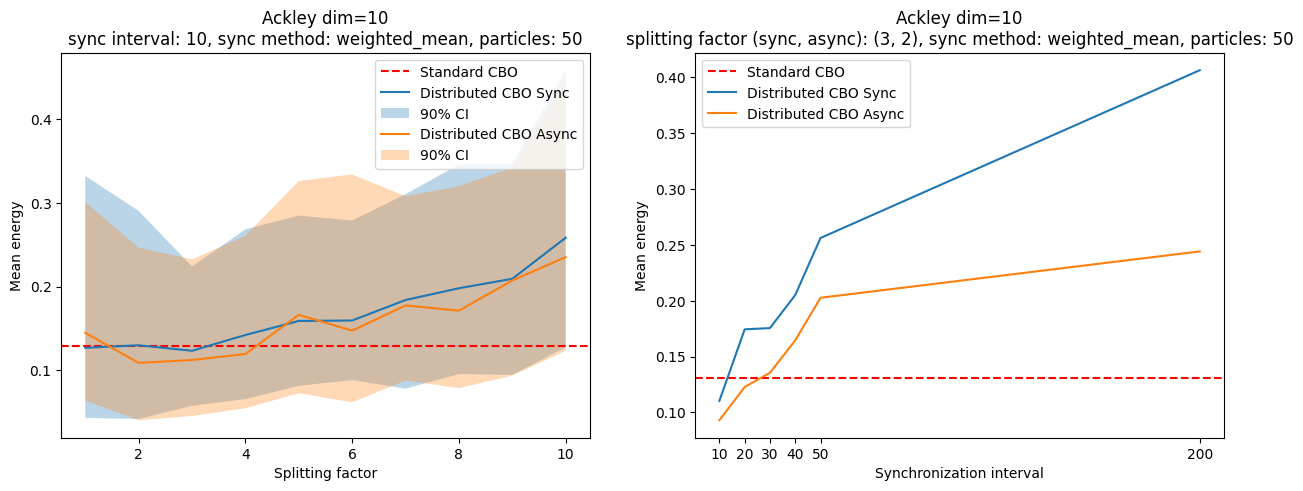

In [9]:
run_experiment(Ackley(), d=10, n=50)

Standard CBO:
Average energy: 0.41751868796203384, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.010429880619049071

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.48175514221775595, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.01810611963272095
Splitting factor: 2, average energy: 0.370093018417903, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.021332736015319823
Splitting factor: 3, average energy: 0.34911561571863503, success_rate: 0.0, function evaluations: 5083.666666666667, execution time: 0.025884331862131755
Splitting factor: 4, average energy: 0.3999224118828413, success_rate: 0.0, function evaluations: 5125.75, execution time: 0.029556747674942017
Splitting factor: 5, average energy: 0.4309933360740339, success_rate: 0.0, function evaluations: 5110.6, execution time: 0.03358065843582153
Splitting factor: 6, average energy: 0.416106203696732, success_rate: 0.0, function evaluat

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_45722/1317182838.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


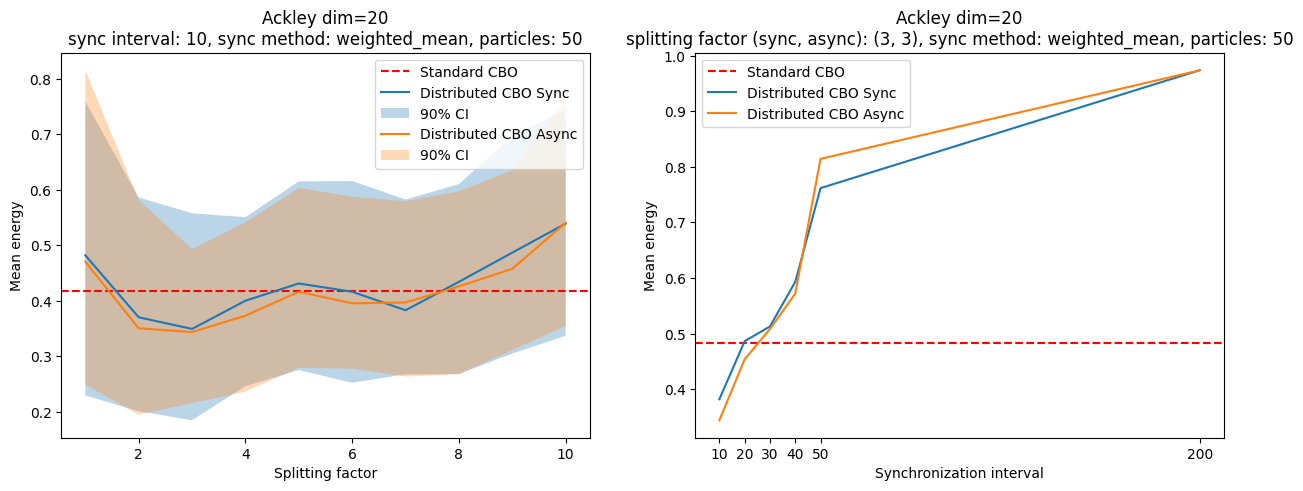

In [10]:
run_experiment(Ackley(), d=20, n=50)

Standard CBO:
Average energy: 0.010692135584561502, success_rate: 0.0, function evaluations: 10100.0, execution time: 0.008412153720855712

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.011089180427582779, success_rate: 0.0, function evaluations: 10100.0, execution time: 0.015793414115905763
Splitting factor: 2, average energy: 0.008440189742329185, success_rate: 0.02, function evaluations: 10100.0, execution time: 0.017995283603668213
Splitting factor: 3, average energy: 0.006981094595197579, success_rate: 0.03, function evaluations: 10167.333333333334, execution time: 0.02159364382425944
Splitting factor: 4, average energy: 0.00812391863894435, success_rate: 0.02, function evaluations: 10150.5, execution time: 0.025578328371047974
Splitting factor: 5, average energy: 0.010157664641381903, success_rate: 0.02, function evaluations: 10140.4, execution time: 0.029752307891845704
Splitting factor: 6, average energy: 0.010037117844050147, success_rate:

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_45722/1317182838.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


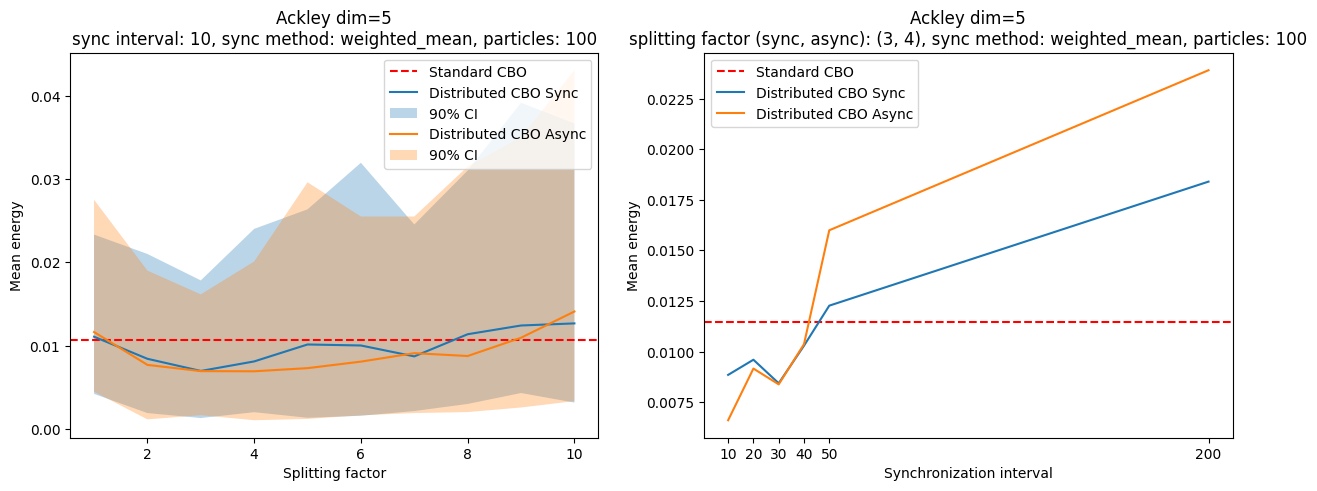

In [11]:
run_experiment(Ackley(), d=5, n=100)

Standard CBO:
Average energy: 0.05980522698542545, success_rate: 0.0, function evaluations: 10100.0, execution time: 0.009864091873168945

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.05744766082439989, success_rate: 0.0, function evaluations: 10100.0, execution time: 0.017661147117614746
Splitting factor: 2, average energy: 0.046431083543256424, success_rate: 0.0, function evaluations: 10100.0, execution time: 0.01959805727005005
Splitting factor: 3, average energy: 0.05221198027118534, success_rate: 0.0, function evaluations: 10167.333333333334, execution time: 0.023292748133341472
Splitting factor: 4, average energy: 0.06096046753912043, success_rate: 0.0, function evaluations: 10150.5, execution time: 0.027415735125541688
Splitting factor: 5, average energy: 0.06288617723352852, success_rate: 0.0, function evaluations: 10140.4, execution time: 0.03178432369232178
Splitting factor: 6, average energy: 0.06697279910916487, success_rate: 0.0, func

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_45722/1317182838.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


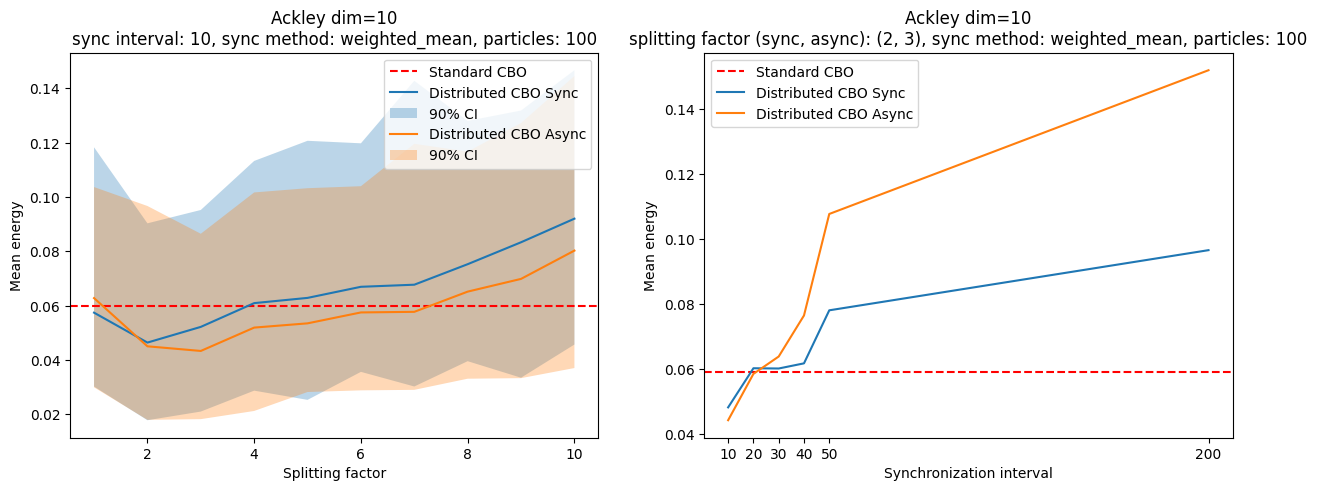

In [12]:
run_experiment(Ackley(), d=10, n=100)

Standard CBO:
Average energy: 0.2362219726161574, success_rate: 0.0, function evaluations: 10100.0, execution time: 0.012976078987121583

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.2503292468873952, success_rate: 0.0, function evaluations: 10100.0, execution time: 0.02009631633758545
Splitting factor: 2, average energy: 0.18210714457308663, success_rate: 0.0, function evaluations: 10100.0, execution time: 0.022951771020889283
Splitting factor: 3, average energy: 0.18950812190767374, success_rate: 0.0, function evaluations: 10167.333333333334, execution time: 0.028061116536458333
Splitting factor: 4, average energy: 0.19027512176715833, success_rate: 0.0, function evaluations: 10150.5, execution time: 0.03191055119037628
Splitting factor: 5, average energy: 0.19507805751933605, success_rate: 0.0, function evaluations: 10140.4, execution time: 0.036043915271759035
Splitting factor: 6, average energy: 0.2077946568325868, success_rate: 0.0, function

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_45722/1317182838.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


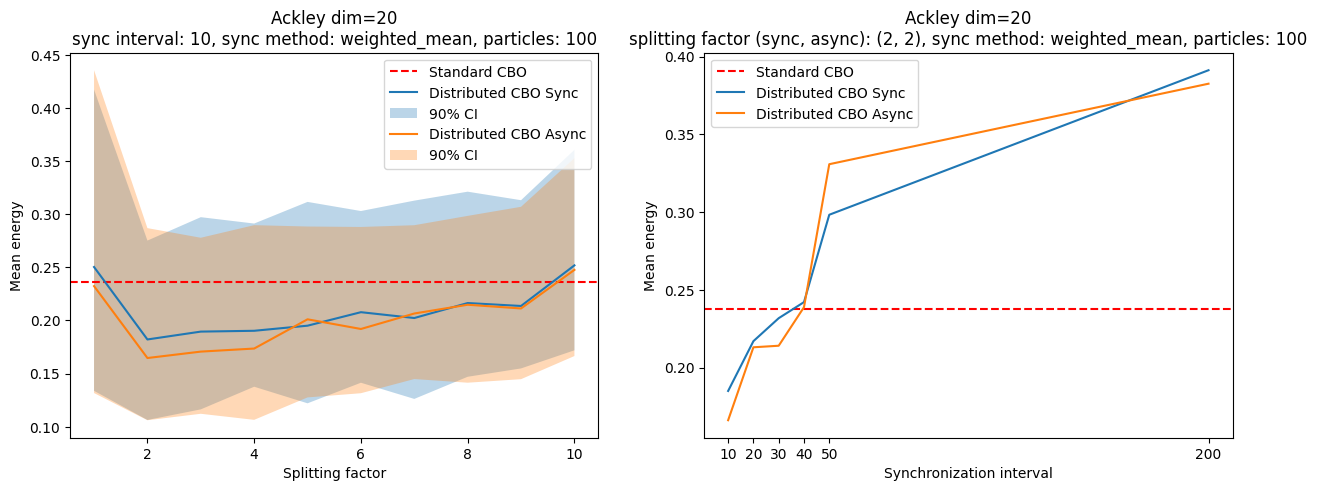

In [13]:
run_experiment(Ackley(), d=20, n=100)

Standard CBO:
Average energy: 0.006323855222874375, success_rate: 0.0, function evaluations: 20200.0, execution time: 0.010423099994659424

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.007363251347760613, success_rate: 0.0, function evaluations: 20200.0, execution time: 0.01849681615829468
Splitting factor: 2, average energy: 0.0071722188087730565, success_rate: 0.03, function evaluations: 20200.0, execution time: 0.0203551983833313
Splitting factor: 3, average energy: 0.005506079427628041, success_rate: 0.03, function evaluations: 20233.666666666668, execution time: 0.0240877628326416
Splitting factor: 4, average energy: 0.005126346570254459, success_rate: 0.01, function evaluations: 20225.25, execution time: 0.02827084720134735
Splitting factor: 5, average energy: 0.005047981891437292, success_rate: 0.01, function evaluations: 20220.2, execution time: 0.0326741943359375
Splitting factor: 6, average energy: 0.00452064654316553, success_rate: 0.05

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_45722/1317182838.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


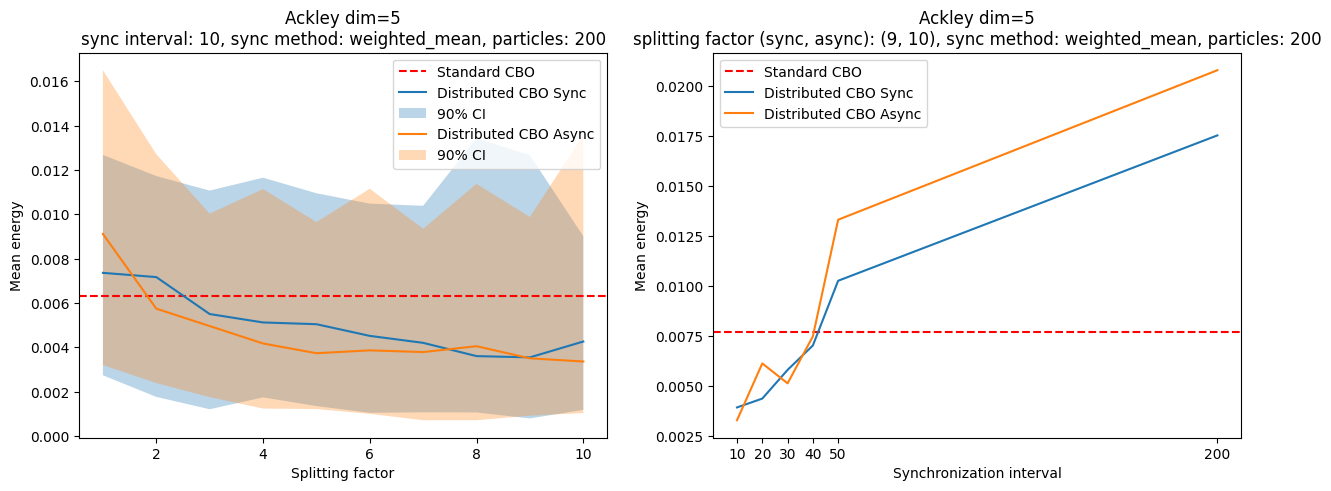

In [14]:
run_experiment(Ackley(), d=5, n=200)

Standard CBO:
Average energy: 0.03439846409055436, success_rate: 0.0, function evaluations: 20200.0, execution time: 0.013150339126586913

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.03375109132022169, success_rate: 0.0, function evaluations: 20200.0, execution time: 0.020518391132354735
Splitting factor: 2, average energy: 0.028699556469800047, success_rate: 0.0, function evaluations: 20200.0, execution time: 0.023438202142715456
Splitting factor: 3, average energy: 0.026300748229847404, success_rate: 0.0, function evaluations: 20233.666666666668, execution time: 0.028341514269510905
Splitting factor: 4, average energy: 0.026995550820729353, success_rate: 0.0, function evaluations: 20225.25, execution time: 0.03210362195968628
Splitting factor: 5, average energy: 0.030911442930531496, success_rate: 0.0, function evaluations: 20220.2, execution time: 0.036208686351776126
Splitting factor: 6, average energy: 0.030539631664352473, success_rate: 0.0

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_45722/1317182838.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


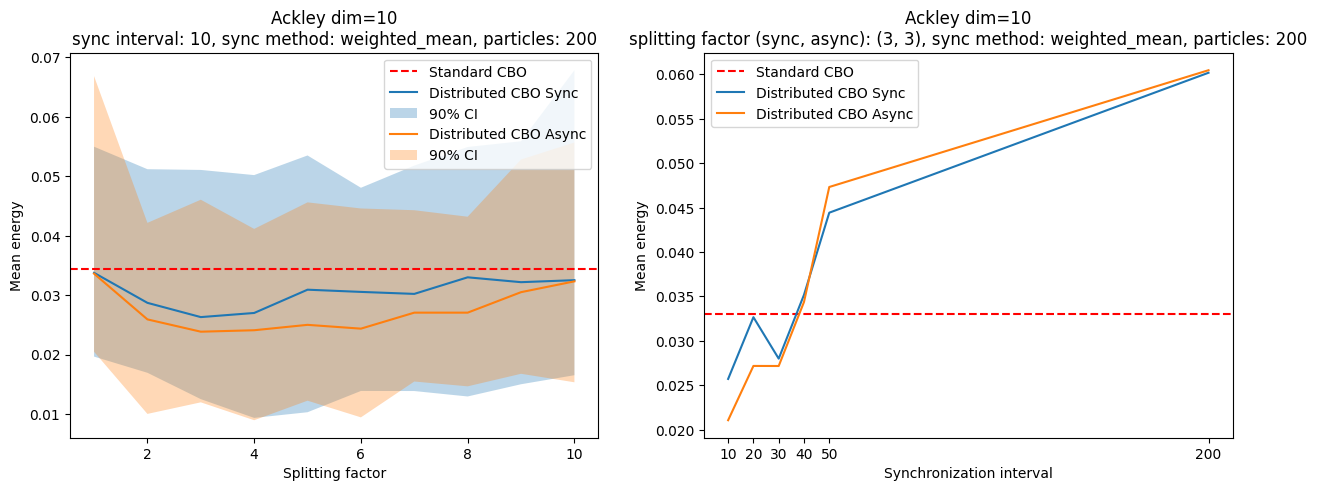

In [15]:
run_experiment(Ackley(), d=10, n=200)

Standard CBO:
Average energy: 0.12731933592745515, success_rate: 0.0, function evaluations: 20200.0, execution time: 0.018764469623565674

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.13300869379974012, success_rate: 0.0, function evaluations: 20200.0, execution time: 0.026350226402282715
Splitting factor: 2, average energy: 0.10231085341668278, success_rate: 0.0, function evaluations: 20200.0, execution time: 0.02788337230682373
Splitting factor: 3, average energy: 0.09551161171193501, success_rate: 0.0, function evaluations: 20233.666666666668, execution time: 0.03286535342534383
Splitting factor: 4, average energy: 0.09821008321869629, success_rate: 0.0, function evaluations: 20225.25, execution time: 0.0384624183177948
Splitting factor: 5, average energy: 0.1047613559694427, success_rate: 0.0, function evaluations: 20220.2, execution time: 0.044390020847320556
Splitting factor: 6, average energy: 0.10717869390114965, success_rate: 0.0, functio

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_45722/1317182838.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


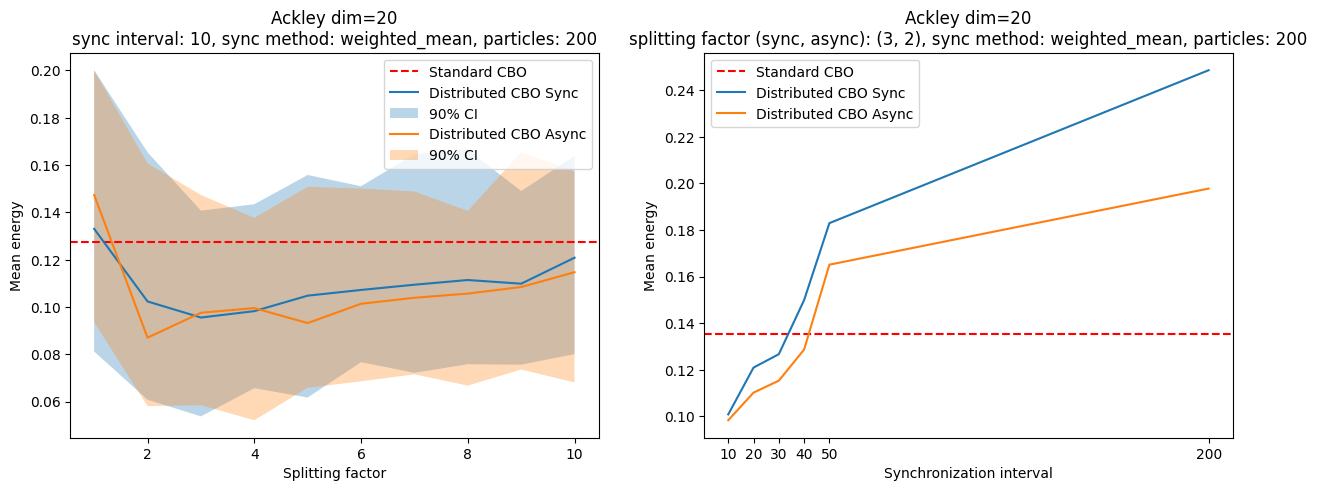

In [16]:
run_experiment(Ackley(), d=20, n=200)

Standard CBO:
Average energy: 0.0029732249375560293, success_rate: 0.04, function evaluations: 101000.0, execution time: 0.026651339530944826

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.0029338450451743547, success_rate: 0.04, function evaluations: 101000.0, execution time: 0.03615213394165039
Splitting factor: 2, average energy: 0.0034200976461122856, success_rate: 0.04, function evaluations: 101000.0, execution time: 0.03550606608390808
Splitting factor: 3, average energy: 0.0028392104955998754, success_rate: 0.07, function evaluations: 101067.33333333333, execution time: 0.03953915198644002
Splitting factor: 4, average energy: 0.0026258738470965604, success_rate: 0.09, function evaluations: 101050.5, execution time: 0.045389879941940305
Splitting factor: 5, average energy: 0.002281950404260602, success_rate: 0.14, function evaluations: 101040.4, execution time: 0.05186615562438965
Splitting factor: 6, average energy: 0.0024240007981455314, su

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_45722/1317182838.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


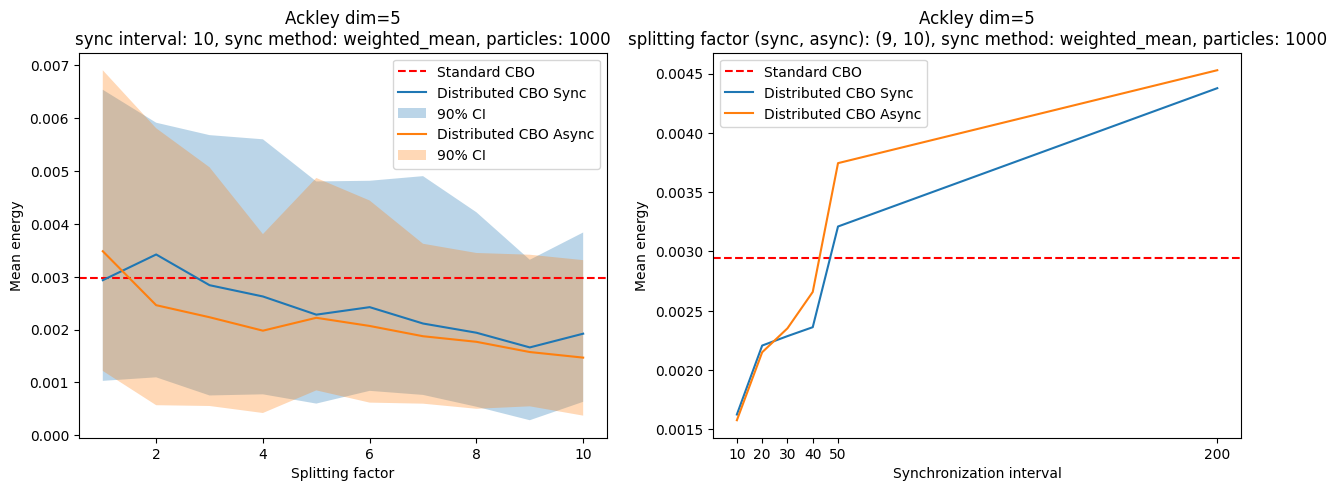

In [17]:
run_experiment(Ackley(), d=5, n=1000)

Standard CBO:
Average energy: 0.01970241704282083, success_rate: 0.0, function evaluations: 101000.0, execution time: 0.04135368824005127

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.019938462956684777, success_rate: 0.0, function evaluations: 101000.0, execution time: 0.04991153955459595
Splitting factor: 2, average energy: 0.017463469420676336, success_rate: 0.0, function evaluations: 101000.0, execution time: 0.054753100872039794
Splitting factor: 3, average energy: 0.013264624007329306, success_rate: 0.0, function evaluations: 101067.33333333333, execution time: 0.05446935733159383
Splitting factor: 4, average energy: 0.012589453138430517, success_rate: 0.0, function evaluations: 101050.5, execution time: 0.058434413075447084
Splitting factor: 5, average energy: 0.012308674425492772, success_rate: 0.0, function evaluations: 101040.4, execution time: 0.06399104452133178
Splitting factor: 6, average energy: 0.010864521890122436, success_rate: 0

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_45722/1317182838.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


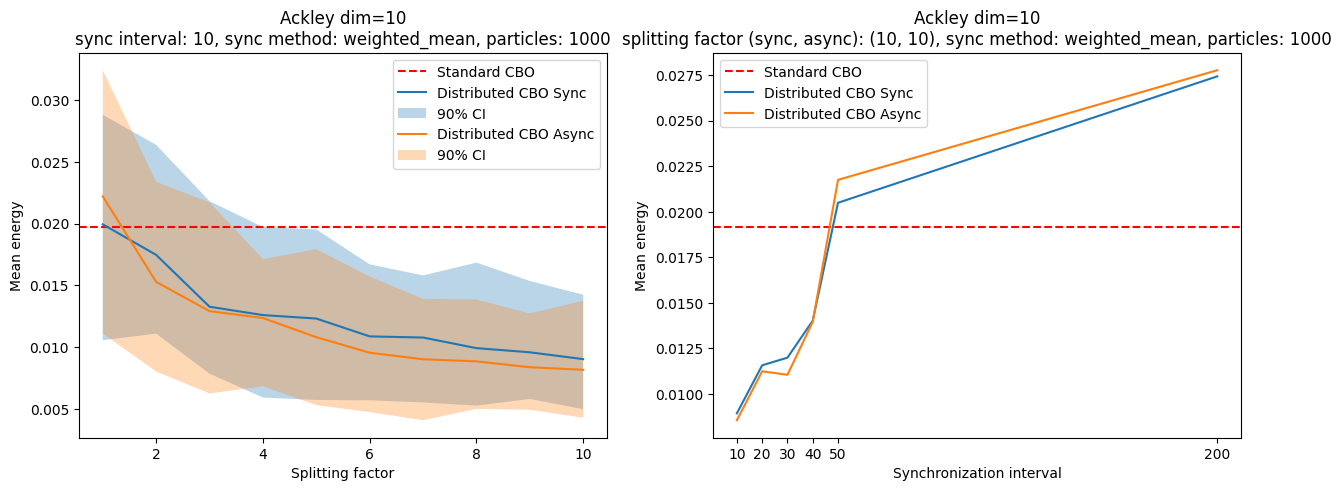

In [18]:
run_experiment(Ackley(), d=10, n=1000)

In [19]:
run_experiment(Ackley(), d=20, n=1000)

Standard CBO:
Average energy: 0.056563807257511645, success_rate: 0.0, function evaluations: 101000.0, execution time: 0.0689638352394104

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.05572941555508182, success_rate: 0.0, function evaluations: 101000.0, execution time: 0.0793382167816162
Splitting factor: 2, average energy: 0.04505933910914495, success_rate: 0.0, function evaluations: 101000.0, execution time: 0.07166162252426148
Splitting factor: 3, average energy: 0.04069440073900532, success_rate: 0.0, function evaluations: 101067.33333333333, execution time: 0.07491567850112915
Splitting factor: 4, average energy: 0.03888047703496911, success_rate: 0.0, function evaluations: 101050.5, execution time: 0.0815330195426941
Splitting factor: 5, average energy: 0.035688847658726264, success_rate: 0.0, function evaluations: 101040.4, execution time: 0.08769413185119629
Splitting factor: 6, average energy: 0.034031641562482395, success_rate: 0.0, func